# StrategicGrowthAnalysis-UniqueGiftsLtd

In [1]:
import requests # for downloading the dataset
import os # for file operations
from tqdm import tqdm  # progress bar library

url = "https://docs.google.com/spreadsheets/d/1RZ0nYqAUgSivbfIiMsbZfEy2yg5KzNBcbGThzDPHx7c/export?format=csv"
file_path = "../data/dataset.csv" # Path to save the dataset

os.makedirs("../data", exist_ok=True)

response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))
block_size = 1024  # 1 KB

print("Downloading dataset with progress:")

with open(file_path, "wb") as file, tqdm(
    desc=file_path,
    total=total_size,
    unit='iB',
    unit_scale=True,
    unit_divisor=1024,
) as bar:
    for data in response.iter_content(block_size):
        file.write(data)
        bar.update(len(data))

print("Download complete!")



../data/dataset.csv: 89.7MiB [00:50, 1.87MiB/s]

Download complete!


create a function to load the dataset

In [2]:
import pandas as pd

if not os.path.exists(file_path): # Check if the file exists
    raise FileNotFoundError(f"Dataset file not found at {file_path}. Please check the download process.")

df = pd.read_csv(file_path) # Load the dataset
print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")


Dataset loaded successfully with 1067371 rows and 8 columns.


your task is to analyze the dataset and provide insights on how UniqueGiftsLtd can strategically grow its business.

In [3]:
# Display the first few rows of the dataset
try:
    df = pd.read_csv('../data/dataset.csv')  # Adjust the path as necessary
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'online_retail.csv' was not found in the 'data' folder.")
    print("Please make sure you have downloaded the dataset and placed it in the correct folder.")

# Display the first 5 rows to get an idea of the data
df.head()

Dataset loaded successfully!


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Have fun creating your demo method using the dataset (df)! 🚀📊😊

In [4]:
print("Dataframe Info:")
df.info()

print("\n" + "="*50 + "\n")

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB




In [5]:
# Get summary statistics for numerical columns
print("Numerical Describe:")
print(df.describe())
print("\n" + "="*50 + "\n")

Numerical Describe:
           Quantity         Price    Customer ID
count  1.067371e+06  1.067371e+06  824364.000000
mean   9.938898e+00  4.649388e+00   15324.638504
std    1.727058e+02  1.235531e+02    1697.464450
min   -8.099500e+04 -5.359436e+04   12346.000000
25%    1.000000e+00  1.250000e+00   13975.000000
50%    3.000000e+00  2.100000e+00   15255.000000
75%    1.000000e+01  4.150000e+00   16797.000000
max    8.099500e+04  3.897000e+04   18287.000000




In [6]:
# Count missing values in each column
print("Missing Values Count:")
print(df.isnull().sum())


Missing Values Count:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


# Handle Duplicates & Missing Data)

In [7]:
# Print shape before dropping duplicates
print(f"Shape before dropping duplicates: {df.shape}")

print(df.duplicated().sum())

# Drop duplicate rows
df.drop_duplicates(inplace=True) # re df

# Print shape after dropping duplicates
print(f"Shape after dropping duplicates: {df.shape}")

# Drop rows where Customer ID is missing
df.dropna(subset=['Customer ID'], inplace=True)

# Print shape after dropping missing Customer ID
print(f"Shape after dropping duplicates: {df.shape}")

# Verify that missing Customer IDs are handled
print("\nMissing values after handling Customer ID:")
print(df.isnull().sum())

Shape before dropping duplicates: (1067371, 8)
34335
Shape after dropping duplicates: (1033036, 8)
Shape after dropping duplicates: (797885, 8)

Missing values after handling Customer ID:
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


# Clean Transactional Data

In [8]:
# Remove cancelled orders (Invoice starts with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Ensure quantity is positive
df = df[df['Quantity'] > 0]

# Remove records where price is 0
df = df[df['Price'] > 0]

# Check the shape of the dataframe after cleaning
print(f"Shape after cleaning transactions: {df.shape}")


Shape after cleaning transactions: (779425, 8)


# Filtering Non-Product Charges

In [9]:
# (Assuming 'df' is your dataframe after the initial cleaning)

def is_product_code(code):
    """
    Checks if a stock code is likely a product by seeing if it contains any digit.
    Returns True if it contains a digit, False otherwise.
    e.g., is_product_code('85123A') -> True
           is_product_code('POST')    -> False
    """
    code_str = str(code)
    return any(char.isdigit() for char in code_str)
    # ====================


# --- Identify codes that would be removed using this new logic ---
all_unique_codes = df['StockCode'].unique()
codes_to_be_removed = [code for code in all_unique_codes if not is_product_code(code)]
print(f"Following codes (without any digits) will be removed: {codes_to_be_removed}")


# --- Filtering Step ---
print(f"\nShape before filtering: {df.shape}")

# Apply the function to the 'StockCode' column and keep only the rows that return True
df = df[df['StockCode'].apply(is_product_code)]

print(f"Shape after filtering: {df.shape}")


Following codes (without any digits) will be removed: ['POST', 'M', 'BANK CHARGES', 'PADS', 'ADJUST', 'D', 'DOT']

Shape before filtering: (779425, 8)
Shape after filtering: (776840, 8)


# Create TotalPrice column


In [10]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

print(df.shape)
print(df.head())

(776840, 9)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  TotalPrice  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom        83.4  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom       100.8  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom        30.0  


# Convert InvoiceDate to datetime


In [11]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(type(df['InvoiceDate']))
print(df['InvoiceDate'].dtype)

# 2. නව columns 4ක් සාදන්න - Year, Month, DayOfWeek, HourOfDay
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek     # Monday=0, Sunday=6
df['HourOfDay'] = df['InvoiceDate'].dt.hour

# 3. බලන්න කොහොම තියෙනද (මුල් 5 rows)
print(df[['InvoiceDate', 'Year', 'Month', 'DayOfWeek', 'HourOfDay']].head())


<class 'pandas.core.series.Series'>
datetime64[ns]
          InvoiceDate  Year  Month  DayOfWeek  HourOfDay
0 2009-12-01 07:45:00  2009     12          1          7
1 2009-12-01 07:45:00  2009     12          1          7
2 2009-12-01 07:45:00  2009     12          1          7
3 2009-12-01 07:45:00  2009     12          1          7
4 2009-12-01 07:45:00  2009     12          1          7


# Convert Customer ID to integer
# Convert Customer ID to integer


In [12]:

df['Customer ID'] = df['Customer ID'].astype(int)  # Convert Customer ID to integer

print(df['Customer ID'].dtype)


int64


# Convert StockCode to string


In [13]:
# Convert StockCode to string
df['StockCode'] = df['StockCode'].astype(str)  # Convert StockCode to string
print(df['StockCode'].dtype)

object


# create cleaned dataset - .csv file

In [14]:
df.to_csv('../data/cleaned-dataset.csv', index=False)

#


# start code with me 

In [15]:
import pandas as pd

df = pd.read_csv('../data/cleaned-dataset.csv')
print(df.columns)


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'TotalPrice', 'Year', 'Month',
       'DayOfWeek', 'HourOfDay'],
      dtype='object')


# first install this = py -m pip install matplotlib seaborn


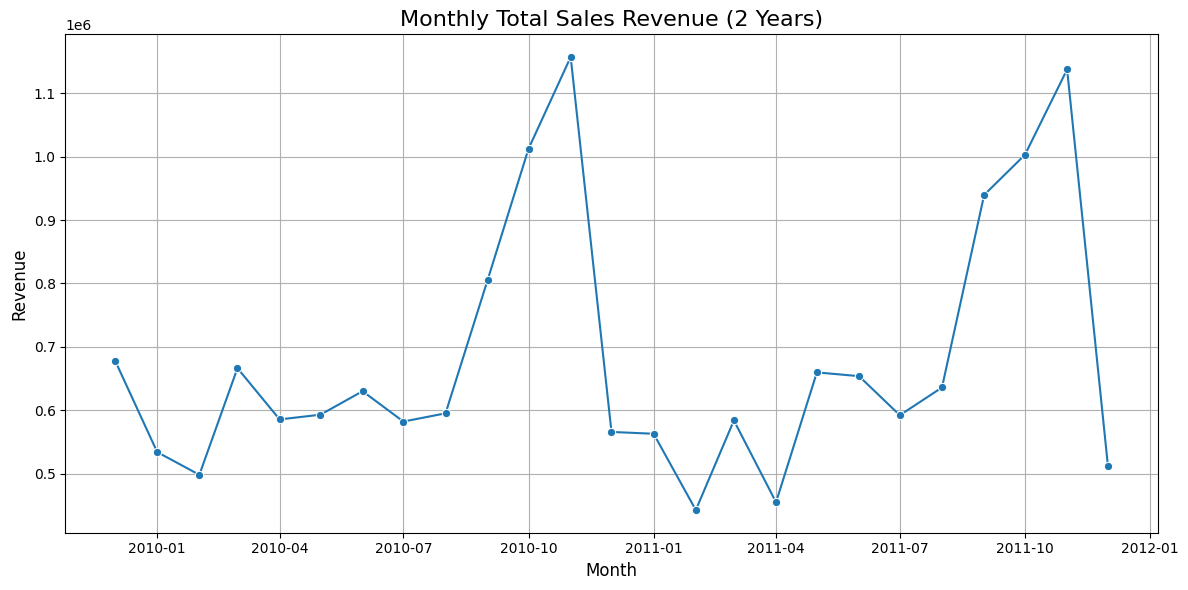

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv('../data/cleaned-dataset.csv')

# Convert 'InvoiceDate' column to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract Year-Month for grouping
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Calculate revenue per row if 'TotalPrice' doesn't already exist or is accurate
# If TotalPrice exists and is correct, use it directly
# Otherwise calculate revenue as Price * Quantity
if 'TotalPrice' in df.columns and df['TotalPrice'].notnull().all():
    df['Revenue'] = df['TotalPrice']
else:
    df['Revenue'] = df['Price'] * df['Quantity']

# Group by YearMonth and sum revenue
monthly_revenue = df.groupby('YearMonth')['Revenue'].sum().reset_index()

# Convert YearMonth to timestamp for plotting
monthly_revenue['YearMonth'] = monthly_revenue['YearMonth'].dt.to_timestamp()

# Plot monthly revenue trend
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue, x='YearMonth', y='Revenue', marker='o')
plt.title('Monthly Total Sales Revenue (2 Years)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


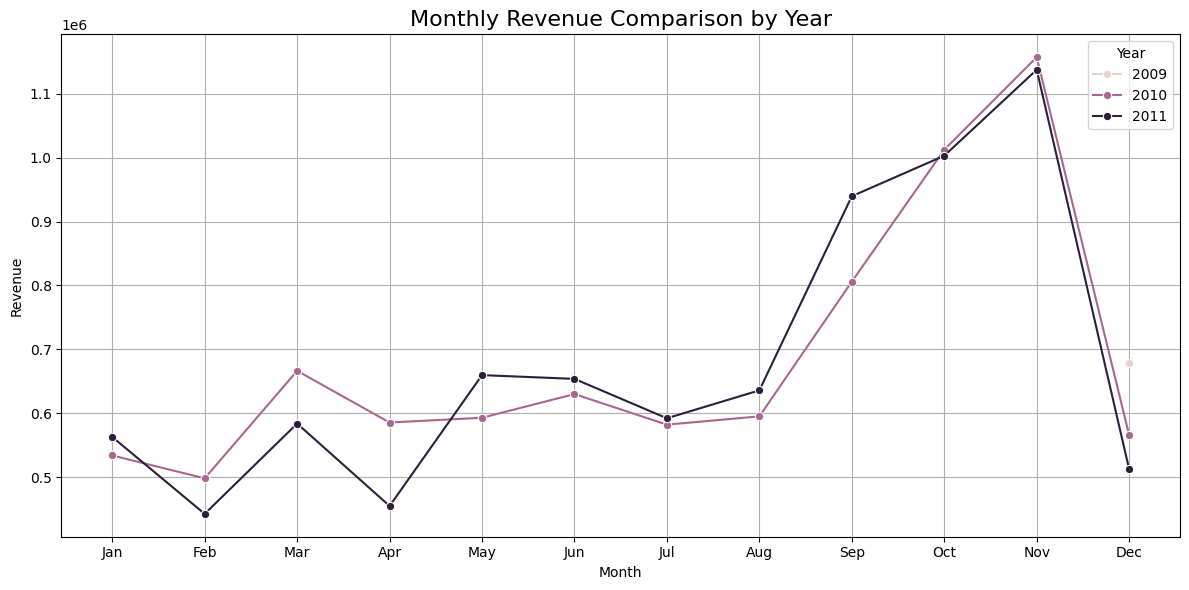

Average revenue for each month:
    Month       Revenue
0       1  5.484179e+05
1       2  4.703156e+05
2       3  6.251088e+05
3       4  5.201704e+05
4       5  6.263063e+05
5       6  6.418777e+05
6       7  5.871259e+05
7       8  6.154878e+05
8       9  8.727987e+05
9      10  1.007724e+06
10     11  1.147456e+06
11     12  5.855024e+05

Average revenue for February and April:
   Month     Revenue
1      2  470315.580
3      4  520170.405


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset load
df = pd.read_csv('../data/cleaned-dataset.csv')

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract Month and Year
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year

# Revenue calculation
if 'TotalPrice' in df.columns and df['TotalPrice'].notnull().all():
    df['Revenue'] = df['TotalPrice']
else:
    df['Revenue'] = df['Price'] * df['Quantity']

# Group by Year and Month
monthly_revenue = df.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()

# Plot for visual check
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue, x='Month', y='Revenue', hue='Year', marker='o')
plt.title('Monthly Revenue Comparison by Year', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(range(1, 13), [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate average revenue per month across all years
avg_monthly_revenue = monthly_revenue.groupby('Month')['Revenue'].mean().reset_index()

# Highlight Feb & Apr
feb_apr = avg_monthly_revenue[avg_monthly_revenue['Month'].isin([2, 4])]

print("Average revenue for each month:")
print(avg_monthly_revenue)

print("\nAverage revenue for February and April:")
print(feb_apr)
